### Imports

In [5]:
# general imports 
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
sns.set()

# model
from sklearn.ensemble import RandomForestClassifier

# optuna
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING) 

# shap
import shap
shap.initjs()

# utils
from utils import *

In [6]:
df_train = pd.read_csv("train.csv")
df_valid = pd.read_csv("valid.csv")
df_test = pd.read_csv("test.csv")

X_train, y_train, X_valid, y_valid, X_test, y_test = with_resampling(df_train, df_valid, df_test)


### Optuna Hyperparameter Tuning

#### Finding hyperparameter with the best recall

In [7]:
#Step 1. Define an objective function to be maximized.
def objective(trial):
    
    # Step 2. Setup values for the hyperparameters:
    rf_n_estimators = trial.suggest_int("n_estimators", 10, 1000)
    rf_max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
    rf_min_samples_split = trial.suggest_int('min_samples_split', 2, 150)
    rf_min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 60)
    rf_bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    rf_max_features = trial.suggest_categorical("max_features", ['auto', 'sqrt'])
    
    classifier_obj = RandomForestClassifier(
        max_depth=rf_max_depth,
        n_estimators=rf_n_estimators,
        min_samples_split=rf_min_samples_split,
        min_samples_leaf=rf_min_samples_leaf,
        bootstrap = rf_bootstrap,
        max_features=rf_max_features,
        random_state = 0
    )
    
    cl_model = classifier_obj.fit(X_train,y_train)

    # Step 3: Scoring method:
    predictions = cl_model.predict(X_valid)
    return recall_score(y_valid, predictions)


In [8]:
study_recall = optuna.create_study(direction="maximize")
study_recall.optimize(objective, n_trials=50)

In [9]:
trial_recall = study_recall.best_trial
print(f"Trial of Choice: ")
print(f"\tnumber: {trial_recall.number}")
print(f"\tparams: {trial_recall.params}")
print(f"\tvalues: {trial_recall.values}")

Trial of Choice: 
	number: 29
	params: {'n_estimators': 52, 'max_depth': 3, 'min_samples_split': 42, 'min_samples_leaf': 58, 'bootstrap': False, 'max_features': 'sqrt'}
	values: [0.8880597014925373]


In [10]:
rf_test = RandomForestClassifier(random_state=0)
rf_test.set_params(**trial_recall.params)
rf_test.fit(X_train,y_train)

predictions = rf_test.predict(X_valid)
get_scores(y_valid, predictions)

Precision: 0.080
Accuracy: 0.392
Recall: 0.888
F1: 0.147
Fbeta: 0.295
ROC AUC: 0.624
PR AUC: 0.078


<AxesSubplot:title={'center':'Tuned for recall'}, xlabel='Predictions', ylabel='True Labels'>

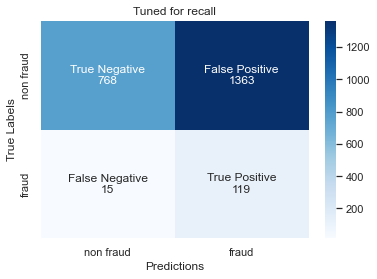

In [11]:
get_confusion_matrix(y_valid,predictions, "Tuned for recall")

#### Finding hyperparameter with the best f2 score

In [12]:
#Step 1. Define an objective function to be maximized.
def objective(trial):
    
    # Step 2. Setup values for the hyperparameters:
    rf_n_estimators = trial.suggest_int("n_estimators", 10, 1000)
    rf_max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
    rf_min_samples_split = trial.suggest_int('min_samples_split', 2, 150)
    rf_min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 60)
    rf_bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    rf_max_features = trial.suggest_categorical("max_features", ['auto', 'sqrt'])
    
    classifier_obj = RandomForestClassifier(
        max_depth=rf_max_depth,
        n_estimators=rf_n_estimators,
        min_samples_split=rf_min_samples_split,
        min_samples_leaf=rf_min_samples_leaf,
        bootstrap = rf_bootstrap,
        max_features=rf_max_features,
        random_state = 0
    )
    
    cl_model = classifier_obj.fit(X_train,y_train)

    # Step 3: Scoring method:
    predictions = cl_model.predict(X_valid)

    fbeta = fbeta_score(y_valid, predictions, beta = 2)
    return fbeta


In [13]:
# Step 4: Running it
study_fbeta = optuna.create_study(direction="maximize")
study_fbeta.optimize(objective, n_trials=50)

In [14]:
trial_fbeta = study_fbeta.best_trial

print(f"Trial of Choice: ")
print(f"\tnumber: {trial_fbeta.number}")
print(f"\tparams: {trial_fbeta.params}")
print(f"\tvalues: {trial_fbeta.values}")

Trial of Choice: 
	number: 32
	params: {'n_estimators': 354, 'max_depth': 19, 'min_samples_split': 135, 'min_samples_leaf': 48, 'bootstrap': False, 'max_features': 'auto'}
	values: [0.3430599369085173]


In [15]:
rf_test2 = RandomForestClassifier(random_state=0)
rf_test2.set_params(**trial_fbeta.params)
rf_test2.fit(X_train,y_train)

# make predictions for test data
predictions = rf_test2.predict(X_valid)

# evaluate predictions
get_scores(y_valid, predictions)

Precision: 0.119
Accuracy: 0.694
Recall: 0.649
F1: 0.201
Fbeta: 0.343
ROC AUC: 0.673
PR AUC: 0.098


<AxesSubplot:title={'center':'Tuned for fbeta'}, xlabel='Predictions', ylabel='True Labels'>

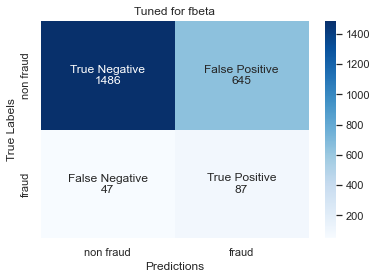

In [16]:
#Confusion Matrix
get_confusion_matrix(y_valid,predictions, "Tuned for fbeta")

#### Making predictions on test set

In [17]:
# make predictions for test data
predictions = rf_test.predict(X_test)

# evaluate predictions
get_scores(y_test, predictions)

Precision: 0.079
Accuracy: 0.462
Recall: 0.761
F1: 0.143
Fbeta: 0.280
ROC AUC: 0.602
PR AUC: 0.074


<AxesSubplot:title={'center':'Test set results'}, xlabel='Predictions', ylabel='True Labels'>

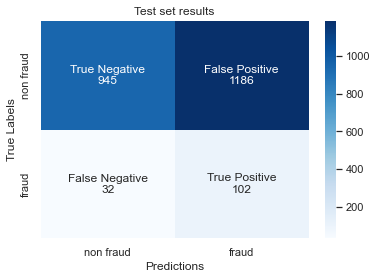

In [18]:
#Confusion Matrix
get_confusion_matrix(y_test, predictions, "Test set results")

### SHAP

In [19]:
import shap
# Fits the explainer
explainer = shap.Explainer(rf_test2.predict, X_train, seed=0)
shap_values = explainer(X_train[1:1000,:])

Permutation explainer: 1000it [14:42,  1.12it/s]                        


In [20]:
#creating a feature list
features  = df_train.drop('FraudFound_P', axis=1).columns.tolist()
feature_dict = {}
for num in range(53):
    feature_key = "f" + str(num)
    feature_dict[feature_key] = features[num]
print(feature_dict)

{'f0': 'MonthClaimed', 'f1': 'VehiclePrice', 'f2': 'Deductible', 'f3': 'DriverRating', 'f4': 'Days_Policy_Accident', 'f5': 'Days_Policy_Claim', 'f6': 'PastNumberOfClaims', 'f7': 'AgeOfVehicle', 'f8': 'AgeOfPolicyHolder', 'f9': 'NumberOfSuppliments', 'f10': 'AddressChange_Claim', 'f11': 'NumberOfCars', 'f12': 'Year', 'f13': 'AccidentArea_IsUrban', 'f14': 'Sex_IsMale', 'f15': 'Fault_IsPolicyholder', 'f16': 'PoliceReportFiled_IsYes', 'f17': 'WitnessPresent_IsYes', 'f18': 'AgentType_IsExternal', 'f19': 'isWithinAgeRange_IsTrue', 'f20': 'Make_Accura', 'f21': 'Make_BMW', 'f22': 'Make_Chevrolet', 'f23': 'Make_Dodge', 'f24': 'Make_Ford', 'f25': 'Make_Honda', 'f26': 'Make_Jaguar', 'f27': 'Make_Lexus', 'f28': 'Make_Mazda', 'f29': 'Make_Mecedes', 'f30': 'Make_Mercury', 'f31': 'Make_Nisson', 'f32': 'Make_Pontiac', 'f33': 'Make_Porche', 'f34': 'Make_Saab', 'f35': 'Make_Saturn', 'f36': 'Make_Toyota', 'f37': 'Make_VW', 'f38': 'MaritalStatus_Divorced', 'f39': 'MaritalStatus_Married', 'f40': 'MaritalSt

In [21]:
X_display = df_train.drop('FraudFound_P', axis=1)

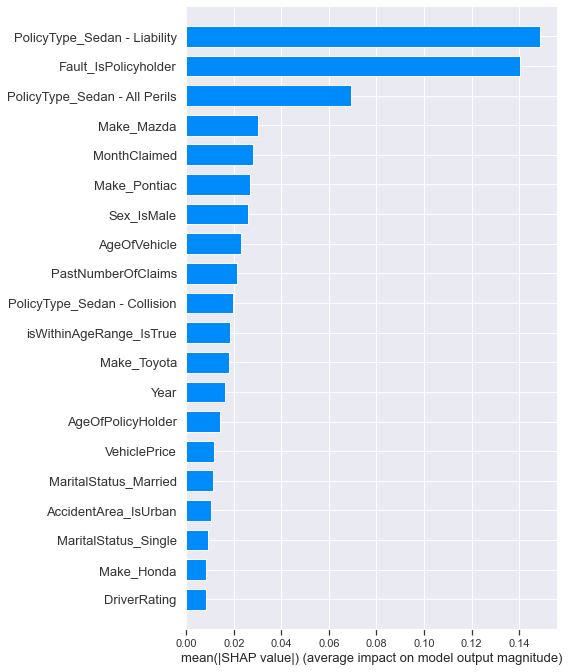

In [22]:
shap.summary_plot(shap_values, X_train, plot_type="bar", feature_names=features)

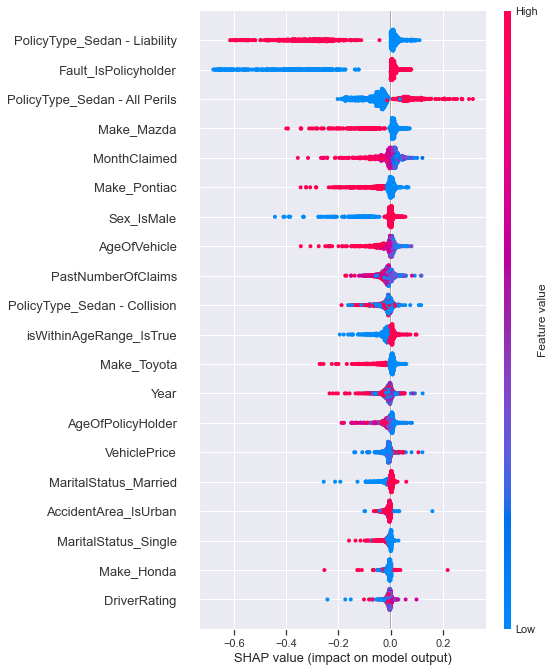

In [23]:
shap.summary_plot(shap_values, X_train[1:1000,:],features)